<a href="https://colab.research.google.com/github/Beatrix-droid/NN-for-text-classification-of-amazonreviews/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


objective: trying to predict the score of a review given a text review.
This machine learning model uses a dataset containing all sorts of amazon reviews.
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information (, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

In [205]:
import pandas as pd

In [206]:
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')

In [207]:
#inspect a sample of the data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [208]:
#drop unnecessary columns:
df.drop(["Id", "ProfileName", "UserId", "ProductId", "Summary","Time", "HelpfulnessNumerator", "HelpfulnessDenominator"], axis=1, inplace=True)

In [209]:
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [210]:
df.shape

(568454, 2)

In [211]:

#as the dataframe is too big for the model to train, we are going to drop the last  15 000 rows
# Dropping last n rows using drop
df.drop(df.tail(500_000).index, inplace = True, axis=0)


In [212]:
df.shape

(68454, 2)

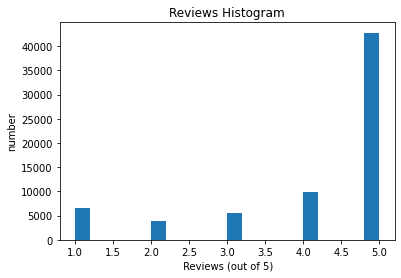

In [213]:
#plot a histogram to visualise the data (what the average review rating is)
import matplotlib.pyplot as plt

plt.hist(df.Score, bins=20)
plt.title("Reviews Histogram")
plt.ylabel("number")
plt.xlabel(" Reviews (out of 5)")
plt.show()

In [214]:
# too many 5 star reviews. Let's drop 40 percent of them:
#first sort df
df.sort_values('Score', ascending=True, inplace=True)
new_df = df[df['Score'].cumsum() / df['Score'].sum() < 0.5]

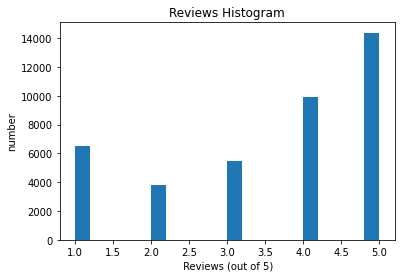

In [215]:
plt.hist(new_df.Score, bins=20)
plt.title("Reviews Histogram")
plt.ylabel("number")
plt.xlabel(" Reviews (out of 5)")
plt.show()

In [216]:
#randomly shuffle the dataframe as we had to order it to delete teh entries with mpore positive reviews
shuffle_df=new_df.sample(frac=1)

In [217]:
shuffle_df.shape

(40055, 2)

In [218]:
#can see that we have  a lot of positive reviews. 
#creating a new model

shuffle_df["good/bad review"] = (df.Score >= 4.0).astype(int)

shuffle_df.head()

,Score,Text,good/bad review
3500,4,This is a very mild hot cocoa. Perfect for th...,1
23056,4,"I do love my morning coffee, but sometimes it ...",1
53934,5,This tea tastes great and really works to help...,1
20236,3,I tried these tea bags at work and they were a...,0
67717,3,"The coffee is good, and you can taste the hint...",0


we have more positive reviews than negative ones. So let's resample

In [219]:
import numpy as np


In [220]:
#split data
train, val, test = np.split(shuffle_df.sample(frac=1), [int(0.8*len(shuffle_df)), int(0.9 * len(shuffle_df))])

In [221]:
len(train), len(val), len(test)

(32044, 4005, 4006)

Using a pretrained embedding layer

tokenization: process of turning paragraphs into sentences, and sentences into words (so sentence is an arr of words (strings))

text vectorization: turning text to numbers

types of vectorization:
count vectorization
ngrams
TFIDF

In [222]:
import tensorflow_hub as hub
import tensorflow as tf

In [223]:
def df_to_dataset(data_df, shuffle=True, batch_size=10):
    shuffle_df=data_df.copy()
    labels=shuffle_df.pop("good/bad review")
    shuffle_df = shuffle_df["Text"]
    data_set = tf.data.Dataset.from_tensor_slices((shuffle_df, labels))#create a tf data.dataset object with data and its labels
    if shuffle:
        data_set=data_set.shuffle(buffer_size=len(data_df))#shuffle data
    data_set = data_set.batch(batch_size) #split dataset into batches of 10 and repeat process for num of epochs
    data_set = data_set.prefetch(tf.data.AUTOTUNE)
    return data_set

In [224]:
train= df_to_dataset(train)
valid= df_to_dataset(val)
test= df_to_dataset(test)

In [225]:
list(train)[0]  #tensor object converted to a list

(<tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b"This is simply the best tea that I have ever found.  The flavors are incredible when combined with sweetener and half and half. Amazon offers this tea at a great price and shipping to my door so I don't have to take a chance on finding it at the store.  If you are looking for a fabulous tasting tea...look no further!  It's here!",
        b"PB2 turned out to be a pretty good alternative to peanut butter. Although its definitely not as sweet it still tastes good on PB and jelly sandwiches and overall I thought it was pretty good. Its no Jiff, but if you are trying to cut back on calories it's a great substitute.",
        b"I have three dogs.  They all loved the Greenies.  One dog does not chew her food, but gulps it whole.  I had to cut the Greenies into smaller portions for her.  It does help clean teeth, but caused diarrhea.  I think I'll look for another product for teeth cleaning.",
        b'I am a big fan of Primal Strips. 

In [226]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"  #Token based text embedding trained on English Google News 7B corpus.
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)


In [227]:
hub_layer(list(train)[0][0]) #sample of what the encoding layer looks like

<tf.Tensor: shape=(10, 50), dtype=float32, numpy=
array([[ 4.13822889e-01, -2.20726699e-01,  2.52028704e-01,
         8.38954523e-02, -1.76592097e-01, -5.05339921e-01,
         2.02273995e-01,  2.25381494e-01, -2.08707958e-01,
         1.06622726e-01, -9.86190662e-02,  1.14561468e-02,
        -8.89717862e-02,  1.98481411e-01, -3.64224762e-01,
        -1.26244381e-01,  1.10348172e-01, -1.19572461e-01,
         4.81777079e-02, -2.98153430e-01, -3.20606023e-01,
        -6.59726918e-01, -2.30479598e-01,  2.05735974e-02,
        -2.55767077e-01, -2.31092677e-01, -4.49654430e-01,
         2.90904164e-01,  1.74041122e-01, -3.16106945e-01,
         7.17811137e-02,  8.49566162e-02,  3.08161855e-01,
        -5.99425673e-01, -8.87756422e-02,  1.07683048e-01,
        -1.40924528e-01,  1.00653827e-01,  2.17472970e-01,
        -3.53431642e-01, -1.50922790e-01,  1.67637169e-02,
        -1.21956252e-01,  3.97201270e-01,  2.72294700e-01,
        -2.34852850e-01,  1.98133543e-01, -4.31361467e-01,
      

In [228]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [229]:
model = tf.keras.Sequential()
model.add(hub_layer) #embeds our words
model.add(tf.keras.layers.Dense(16, activation="relu")) #dense takes input from every preceding neuron
model.add(tf.keras.layers.Dense(16, activation="relu"))       
model.add(tf.keras.layers.Dense(1, activation="sigmoid")) #useful for binary classification as sigmoid maps our feature to a probability

In [230]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
             loss = tf.keras.losses.BinaryCrossentropy(), #binarycross entropy as binary classification problem
                metrics=["accuracy"])

In [231]:
model.evaluate(train) #evaluate performance of model without training it first
#accuracy is around 58%, loss is 0.68

3205/3205 [==============================] - 7s 2ms/step - loss: 0.6830 - accuracy: 0.5828


[0.6830195188522339, 0.582823634147644]

In [ ]:
history=model.fit(train, epochs= 10, validation_data=valid, callbacks=[callback] )

Epoch 1/10
3205/3205 [==============================] - 1785s 557ms/step - loss: 0.4351 - accuracy: 0.7963 - val_loss: 0.3940 - val_accuracy: 0.8260
Epoch 2/10
 123/3205 [>.............................] - ETA: 29:27 - loss: 0.2737 - accuracy: 0.8992

In [ ]:
#create a plot of the training accuracy and validation accuracy (both should increase)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlablel("Number of Epochs")
plt.ylabel("val acc  and training acc scores")
plt.title("A graph showhing the training loss and validation accuracy of the model for each Epoch")
plt.legend()
plt.show()

In [ ]:
#create a plot of the loss and validation loss both should decrease as no of epochs increase
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlablel("Number of Epochs")
plt.ylabel("val loss  and training loss scores")
plt.title("A graph showhing the training loss and validation loss of the model for each Epoch")
plt.legend()
plt.show()

In [ ]:
#evaluate model
model.evaluate(valid)

In [ ]:
model.evaluate(test)

problem: the model seems to overfit. This becomes even more apparent if one removes the optional Earlystopping parameter 
 included in the demo given lack of time to train the model for the full 10 epochs

 One suggested way of fixing this would be adding a dropout layer to the model to increase randomness and force it to be more
 capable at generalising. This layer would be added after the first dense layer

from the tf.keras docs:

" The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged." Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. 

In [ ]:
model2 = tf.keras.Sequential()
model2.add(hub_layer) #embeds our words
model2.add(tf.keras.layers.Dense(16, activation="relu")) #dense takes input from every preceding neuron
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(16, activation="relu"))    
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid")) 

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
             loss = tf.keras.losses.BinaryCrossentropy(), #binarycross entropy as binary classification problem
                metrics=["accuracy"])

In [ ]:
model2.evaluate(train) #evaluate performance of model without training it first
#accuracy is around 50%, loss is 0.69

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train.map(lambda x, y: x))